In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

def extract_amount(text):
    return float(text.replace('$', ''))

def extract_keystroke_dynamics(text):
    return [float(x) for x in text.strip('[]').split(', ')]

def extract_scroll_speed(text):
    return float(text.split(', ')[1].split('px/s')[0].split(': ')[1])

def extract_scroll_length(text):
    return float(text.split('px,')[0].split(': ')[1])


In [58]:
df = pd.read_csv(r"C:\Users\arnav\Desktop\credit_card_fraud_detection_data.csv")

df['Transaction Amount'] = df['Transaction Amount'].apply(extract_amount)
keystroke_dynamics = df['Keystroke Dynamics'].apply(extract_keystroke_dynamics)
df[['Keystroke Dynamics 1', 'Keystroke Dynamics 2', 'Keystroke Dynamics 3']] = pd.DataFrame(keystroke_dynamics.tolist())
df['Scroll Speed'] = df['Scroll Patterns'].apply(extract_scroll_speed)
df['Scroll Length'] = df['Scroll Patterns'].apply(extract_scroll_length)
df['Device Orientation'] = df['Device Orientation'].fillna('Unknown')
df['Is Fraud'] = df['Is Fraud'].map({'Yes': 1, 'No': 0})
df.drop(columns=['User ID', 'Transaction ID', 'Timestamp', 'Device ID', 'IP Address', 'Keystroke Dynamics', 'Scroll Patterns', 'Touch Dynamics', 'Gesture Dynamics'], inplace=True)


In [59]:
categorical_cols = ['Location', 'Device Orientation', 'Transaction Type', 'Merchant Category', 'Browser Type', 'Operating System']
numerical_cols = ['Transaction Amount', 'Keystroke Dynamics 1', 'Keystroke Dynamics 2', 'Keystroke Dynamics 3', 'Scroll Speed', 'Scroll Length']

numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols), ('cat', categorical_transformer, categorical_cols)])

X = df.drop('Is Fraud', axis=1)
y = df['Is Fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [60]:
rf_model = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf_model)])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.67      0.86      0.75      1492
           1       0.80      0.57      0.67      1492

    accuracy                           0.71      2984
   macro avg       0.73      0.71      0.71      2984
weighted avg       0.73      0.71      0.71      2984



C:\Users\arnav\AppData\Local\Temp\ipykernel_32808\3614666893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="inferno")


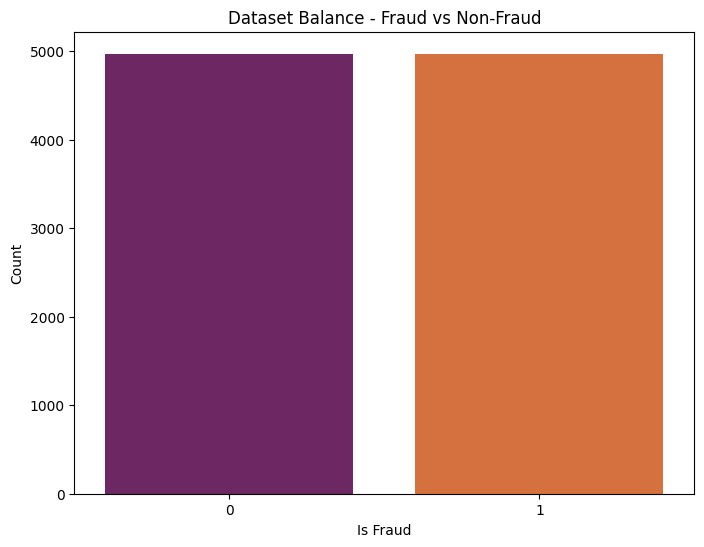

In [76]:
fraud_counts = df['Is Fraud'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="inferno")
plt.title('Dataset Balance - Fraud vs Non-Fraud')
#plt.xlabel('Is Fraud')
plt.ylabel('Count')
#plt.xticks(range(len(fraud_counts.index)), ['No Fraud', 'Fraud'])
plt.show()


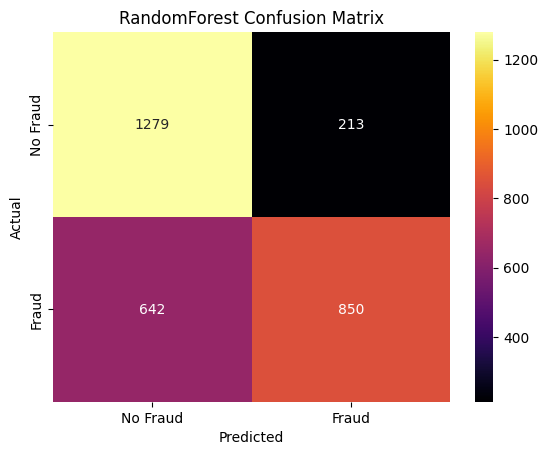

In [64]:
conf_mat = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='inferno', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('RandomForest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


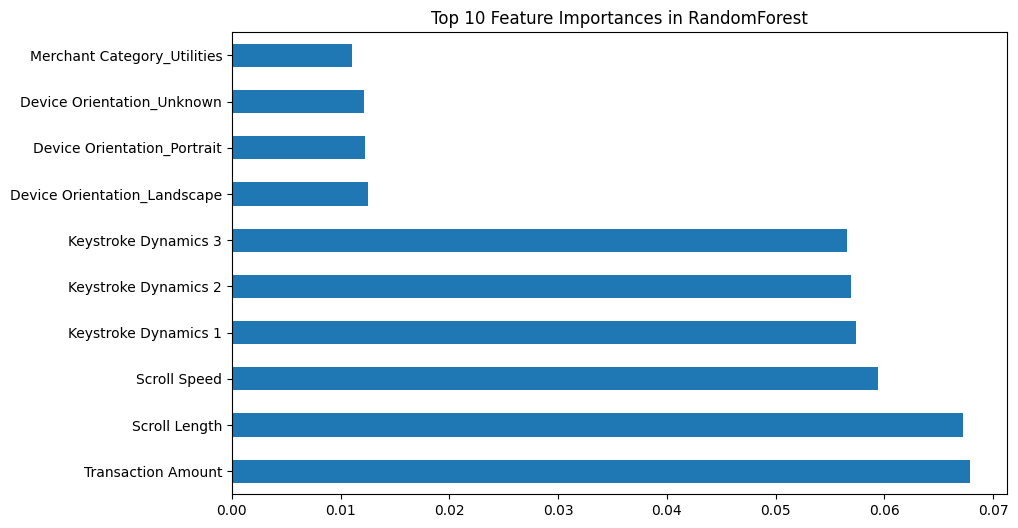

In [78]:
features = numerical_cols + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols))
importances = rf_pipeline.named_steps['model'].feature_importances_
feature_importances = pd.Series(importances, index=features)

plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances in RandomForest')
plt.show()


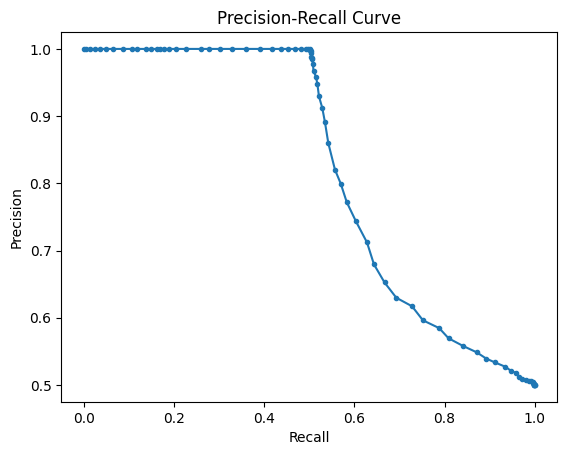

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


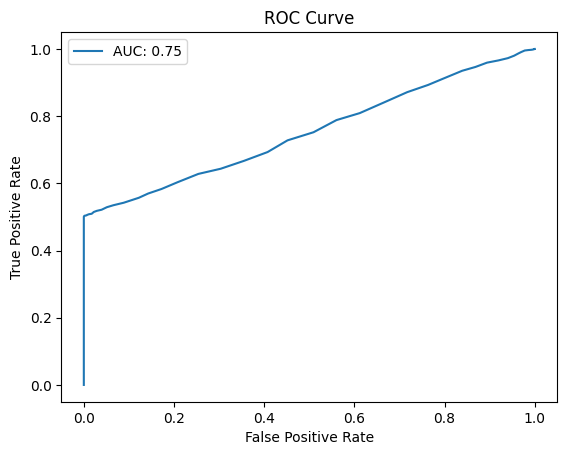

In [80]:
fpr, tpr, _ = roc_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
auc_score = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label=f'AUC: {auc_score:.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
